In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_csv("NY property data.csv")
df.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


#### 1. remove not interested owners

In [3]:
remove_list = ['PARKCHESTER PRESERVAT', 'PARKS AND RECREATION', 'DCAS', 'HOUSING PRESERVATION', 
        'CITY OF NEW YORK', 'DEPT OF ENVIRONMENTAL', 'BOARD OF EDUCATION', 'NEW YORK CITY HOUSING', 
        'CNY/NYCTA', 'NYC HOUSING PARTNERSH', 'DEPARTMENT OF BUSINES', 'DEPT OF TRANSPORTATIO', 
        'MTA/LIRR', 'PARCKHESTER PRESERVAT', 'MH RESIDENTIAL 1, LLC', 'LINCOLN PLAZA ASSOCIA', 
        'UNITED STATES OF AMER', 'U S GOVERNMENT OWNRD', 'THE CITY OF NEW YORK', 'NYS URBAN DEVELOPMENT',
        'NYS DEPT OF ENVIRONME', 'CULTURAL AFFAIRS', 'DEPT OF GENERAL SERVI', 'DEPT RE-CITY OF NY']
property_data = df[~df.OWNER.isin(remove_list)].copy()

#### 2. fill in `ZIP`

In [4]:
property_data = property_data.reset_index()

In [5]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21772

In [6]:
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1, 'ZIP'] == property_data.loc[missing_zips[i]-1, 'ZIP']):
        property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [7]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10245

In [8]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']
        

In [9]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

#### 3. fill in `FULLVAL`, `AVLAND`, and `AVTOT`

In [10]:
property_data['FULLVAL'].replace('NaN', 0)
temp = property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
mean_fullval

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64

In [11]:
property_data['AVLAND'].replace('NaN', 0)
temp = property_data[property_data['AVLAND']!=0]
mean_avland = temp.groupby('TAXCLASS')['AVLAND'].mean()
mean_avland

TAXCLASS
1      14901.860425
1A      2247.472465
1B      9185.394750
1C      8225.658898
1D    709303.793103
2      88471.102578
2A     31370.740197
2B     54607.394911
2C     25635.944099
3      28135.636364
4     444996.049088
Name: AVLAND, dtype: float64

In [12]:
property_data['AVTOT'].replace('NaN', 0)
temp = property_data[property_data['AVTOT']!=0]
mean_avtot = temp.groupby('TAXCLASS')['AVTOT'].mean()
mean_avtot

TAXCLASS
1     2.502549e+04
1A    1.437036e+04
1B    9.189080e+03
1C    2.898447e+04
1D    1.166866e+06
2     3.602638e+05
2A    7.963525e+04
2B    1.790961e+05
2C    1.170418e+05
3     3.829505e+04
4     1.294237e+06
Name: AVTOT, dtype: float64

In [13]:
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL'] == 0) & (property_data['TAXCLASS'] == index),'FULLVAL'] = mean_fullval[index]
    property_data.loc[(property_data['AVLAND'] == 0) & (property_data['TAXCLASS'] == index),'AVLAND'] = mean_avland[index]
    property_data.loc[(property_data['AVTOT'] == 0) & (property_data['TAXCLASS'] == index),'AVTOT'] = mean_avtot[index]

#### 4. fill in `STORIES`

In [14]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43968

In [15]:
len(property_data[property_data['STORIES']==0])

0

In [16]:
temp['TAXCLASS'].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [17]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
mean_stories

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64

In [18]:
property_data['STORIES'] = property_data['STORIES'].fillna(value=0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES'] == 0) & (property_data['TAXCLASS'] == index), 'STORIES'] = mean_stories[index]

In [19]:
#property_data.head().transpose()

#### 5. fill in `LTFRONT`, `LTDEPTH`, `BLDFRONT`, and `BLDDEPTH`

In [20]:
#convert 0 & 1 to NA to prepare for mean calculation
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan

property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan


In [21]:
#mean
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

In [22]:
#imputation
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]


#### 6. make variables

In [23]:
# zip to int
property_data['ZIP'] = property_data['ZIP'].astype(str)
property_data['ZIP3'] = property_data['ZIP'].str[:3]

In [24]:
#create 3 variables
property_data['ltsize'] = property_data.LTFRONT * property_data.LTDEPTH
property_data['bldsize'] = property_data.BLDFRONT * property_data.BLDDEPTH
property_data['bldvol'] = property_data.bldsize * property_data.STORIES

In [25]:
#create 9 variables
property_data['r1'] = property_data['FULLVAL'] / property_data['ltsize']
property_data['r2'] = property_data['FULLVAL'] / property_data['bldsize']
property_data['r3'] = property_data['FULLVAL'] / property_data['bldvol']

property_data['r4'] = property_data['AVLAND'] / property_data['ltsize']
property_data['r5'] = property_data['AVLAND'] / property_data['bldsize']
property_data['r6'] = property_data['AVLAND'] / property_data['bldvol']

property_data['r7'] = property_data['AVTOT'] / property_data['ltsize']
property_data['r8'] = property_data['AVTOT'] / property_data['bldsize']
property_data['r9'] = property_data['AVTOT'] / property_data['bldvol']

In [26]:
#create 45 variables
ninevars = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9']

zip5_mean = property_data.groupby('ZIP')[ninevars].mean()
zip3_mean = property_data.groupby('ZIP3')[ninevars].mean()
taxclass_mean = property_data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = property_data.groupby('B')[ninevars].mean()

property_data = property_data.join(zip5_mean, on='ZIP', rsuffix = '_zip5')
property_data = property_data.join(zip3_mean, on='ZIP3', rsuffix = '_zip3')
property_data = property_data.join(taxclass_mean, on='TAXCLASS', rsuffix = '_taxclass')
property_data = property_data.join(borough_mean, on='B', rsuffix = '_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']

for var in ninevars:
    for r in rsuffix:
        property_data[str(var)+r] = property_data[var] / property_data[str(var)+r]

In [27]:
nyvar = property_data.iloc[:, -45:]
submit = pd.DataFrame(nyvar.count(), columns = ['count'])
submit['mean'] = round(nyvar.mean(), 2)
submit['std'] = round(nyvar.std(), 2)
submit['min'] = nyvar.min()
submit['25%'] = round(nyvar.quantile(0.25), 2)
submit['50%'] = round(nyvar.quantile(0.5), 2)
submit['75%'] = round(nyvar.quantile(0.75), 2)
submit['max'] = round(nyvar.max(), 2)
submit

,count,mean,std,min,25%,50%,75%,max
r1,1046826,213.57,532.56,3.905765e-04,76.26,152.86,243.18,138637.34
r2,1046826,536.42,1027.44,7.466192e-04,211.82,500.00,683.82,310551.57
r3,1046826,244.08,498.82,8.983394e-05,82.50,239.06,336.23,227500.00
r4,1046826,10.46,69.98,8.333333e-06,2.35,4.60,7.23,22249.80
r5,1046826,22.82,378.51,2.096125e-04,6.20,14.98,20.29,334636.37
r6,1046826,10.04,178.33,1.038033e-05,2.02,7.15,10.04,111545.46
r7,1046826,26.83,203.87,8.333333e-06,5.28,8.58,13.53,64711.85
r8,1046826,50.46,932.20,3.062474e-04,17.47,26.98,36.00,871362.22
r9,1046826,19.07,327.02,6.049251e-05,7.09,12.68,17.58,290454.07
r1_zip5,1046826,1.00,2.16,2.228349e-06,0.46,0.92,1.23,747.76


In [28]:
#submit.to_csv('variable_statistics.csv')

In [29]:
nyvar

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,40.917782,3994.412456,723.985188,8.079350,788.709805,142.953243,18.413002,1797.485605,325.793334,0.096029,...,4.715588,0.113902,7.712077,6.469193,0.241395,16.606462,13.685555,0.198288,14.042014,14.957255
1,57678.882190,36173.697854,6556.463990,4258.951518,2671.030012,484.122805,25955.496986,16278.164034,2950.408795,135.364878,...,42.704717,160.560217,69.841147,58.585497,127.249178,56.239136,46.347248,279.513149,127.165526,135.454020
2,385.182796,736.308714,14.726174,62.110738,118.729804,2.374596,173.332268,331.338940,6.626779,0.903974,...,0.095917,1.072230,1.421603,0.131586,1.855748,2.499883,0.227331,1.866605,2.588430,0.304237
3,556.662267,1064.105879,21.282118,89.761892,171.587267,3.431745,250.498069,478.847739,9.576955,1.306414,...,0.138618,1.549576,2.054487,0.190167,2.681911,3.612808,0.328536,2.697598,3.740773,0.439680
4,1035.027624,1978.540749,39.570815,94.470682,180.588507,3.611770,465.762431,890.343337,17.806867,2.429076,...,0.257740,2.881198,3.820001,0.353586,2.822600,3.802332,0.345771,5.015767,6.955390,0.817518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046821,60.833333,561.538462,224.615385,2.018889,18.635897,7.454359,3.239167,29.900000,11.960000,0.423922,...,0.824086,0.398834,1.200624,0.879509,0.226228,1.008640,0.738326,0.150641,0.942288,0.685258
1046822,38.483305,653.846154,261.538462,0.658107,11.181490,4.472596,1.056098,17.943510,7.177404,0.268174,...,0.494548,0.252303,1.397986,1.024085,0.073745,0.605181,0.442994,0.049115,0.565484,0.411235
1046823,33.174373,625.000000,312.500000,1.022185,19.257812,9.628906,1.587878,29.915365,14.957682,0.231178,...,1.030636,0.217497,1.336310,1.223631,0.114542,1.042300,0.953706,0.073846,0.942772,0.857013
1046824,76.781674,808.035714,404.017857,1.751697,18.434524,9.217262,3.257494,34.281250,17.140625,0.535059,...,1.181049,0.503394,1.727658,1.581981,0.196288,0.997741,0.912935,0.151494,1.080362,0.982087


In [36]:
#scaling
nyvar_zscal = (nyvar - nyvar.mean()) / nyvar.std()
nyvar_zscal

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.324189,3.365634,0.962071,-0.034088,2.023461,0.745320,-0.041301,1.874086,0.937911,-0.417857,...,0.660210,-0.374523,3.352458,2.151291,-0.120245,0.910164,0.790755,-0.110174,0.594662,0.887478
1,107.903135,34.685411,12.654552,60.713604,6.996480,2.658471,127.179921,17.407961,8.963675,62.109671,...,7.410371,67.440601,34.383853,22.651090,20.011593,3.221530,2.826725,38.274168,5.752631,8.549314
2,0.322241,0.194554,-0.459794,0.738056,0.253399,-0.042992,0.718576,0.301305,-0.038062,-0.044388,...,-0.160643,0.030529,0.210577,-0.341588,0.135643,0.087473,-0.048164,0.119092,0.072426,-0.044240
3,0.644229,0.513596,-0.446651,1.133208,0.393046,-0.037064,1.097074,0.459542,-0.029041,0.141639,...,-0.153056,0.232287,0.526681,-0.318545,0.266597,0.152378,-0.041856,0.233289,0.124968,-0.035628
4,1.542460,1.403606,-0.409988,1.200500,0.416827,-0.036055,2.152944,0.900967,-0.003875,0.660585,...,-0.131890,0.795117,1.408496,-0.254265,0.288898,0.163431,-0.040781,0.551860,0.271541,-0.011603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046821,-0.286793,0.024452,-0.039025,-0.120696,-0.011046,-0.014507,-0.115729,-0.022058,-0.021754,-0.266290,...,-0.031258,-0.254092,0.100205,-0.047395,-0.122650,0.000504,-0.016311,-0.116722,-0.002631,-0.020013
1046822,-0.328760,0.114294,0.034995,-0.140142,-0.030740,-0.031228,-0.126437,-0.034884,-0.036378,-0.338284,...,-0.089812,-0.316026,0.198781,0.009474,-0.146820,-0.023026,-0.034721,-0.130674,-0.019812,-0.037437
1046823,-0.338729,0.086218,0.137159,-0.134939,-0.009403,-0.002313,-0.123829,-0.022041,-0.012587,-0.355385,...,0.005444,-0.330737,0.167976,0.087965,-0.140353,0.002467,-0.002886,-0.127275,-0.002609,-0.009092
1046824,-0.256847,0.264365,0.320626,-0.124514,-0.011578,-0.004621,-0.115639,-0.017358,-0.005912,-0.214917,...,0.032170,-0.209898,0.363441,0.228920,-0.127395,-0.000132,-0.005427,-0.116604,0.003664,-0.001139


(0.0, 1.0)

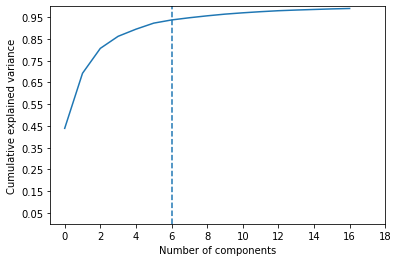

In [40]:
#pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = .99, svd_solver = 'full')

pca.fit(nyvar_zscal)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)


In [41]:
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(nyvar_zscal)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape


(1046826, 6)

In [42]:
#scaling
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()


,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,4.779822e-17,8.883600e-16,1.185792e-16,-1.885932e-15,3.473618e-15,-1.090902e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438862e+02,-2.002481e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269406e-02,-1.159065e-01,-1.101834e-01
50%,-2.375699e-02,-5.919442e-02,6.964988e-04,1.366904e-02,-1.313849e-02,-2.535170e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018388e-02,4.879437e-02,1.382264e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507934e+02,4.068853e+02,4.017216e+02


In [44]:
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p

In [47]:
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop


Epoch 1/3
32714/32714 [==============================] - 71s 2ms/step - loss: 1.0469 - val_loss: 0.8969
Epoch 2/3
32714/32714 [==============================] - 67s 2ms/step - loss: 0.8967 - val_loss: 0.8960
Epoch 3/3
32714/32714 [==============================] - 63s 2ms/step - loss: 1.0162 - val_loss: 0.8960


In [48]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
top_records = scores.sort_values(['final'], ascending = False).head(100).index

In [49]:
top_records

Int64Index([ 898846,  667828, 1042136, 1036415,  148125,   39267,  115122,
              11988,   33294,  648382,  241789,  914593,  317882,  105181,
              33107,   47704,  753749,  735155,  137449,  594392,   94946,
              55582,  232192,  317883,  648381,  102923,  622448,   14878,
             633027,  953143,  105223,  799571,   59907,  803133,  152679,
             799624,  893638,  206300,  107556,     413,  383734,     407,
              85924,   55581,   41418,   47468,    7030,  667687,  970553,
             898849,  973757,  973759,  973761,  973755,   88314,  694913,
             627152,   22981,    7032,  973763,   63702,  565123,  971098,
             898848,  984763,   56413,  115121,   29934,   87359,   73443,
             800347,  499768,  668040,  906638,  587330,  914592,   43737,
                  1,   84943,  563493,   88313,  297298,  236160,   89163,
            1039216,    3822,  242437,  876550,  111951,  314946,  954277,
             954279,  954

(0.1, 2088582.7348885664)

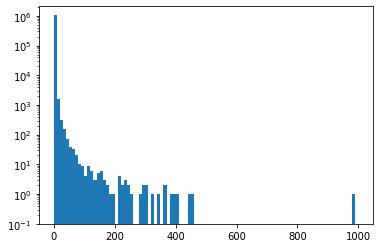

In [50]:
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2090069.2702101301)

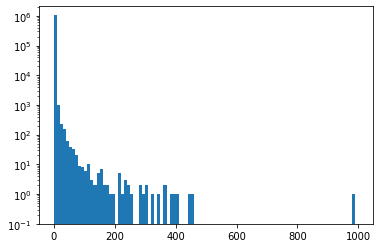

In [53]:
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

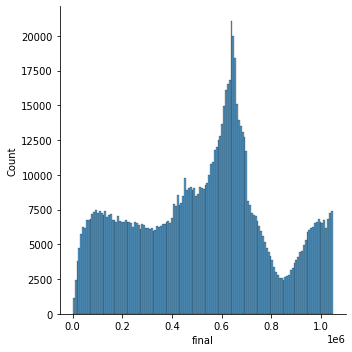

In [54]:
import seaborn as sns
sns.displot(scores['final'])

In [55]:
scores

,score1,score2,score1 rank,score2 rank,final
0,3.811838,2.150695,1032993.0,1032087.0,1032540.0
1,88.407892,86.147691,1046749.0,1046748.0,1046748.5
2,0.590117,0.533934,894887.0,993473.0,944180.0
3,0.941790,0.768488,978677.0,1009356.0,994016.5
4,2.002900,1.330252,1019632.0,1024199.0,1021915.5
...,...,...,...,...,...
1046821,0.300942,0.136782,467045.0,702619.0,584832.0
1046822,0.431622,0.155160,624959.0,759699.0,692329.0
1046823,0.393290,0.145842,593741.0,732972.0,663356.5
1046824,0.501636,0.148791,670579.0,741883.0,706231.0


In [81]:
top100 = property_data.iloc[top_records]
top100 = top100[top100.columns[1:-49]]
top100['score1'] = scores.loc[top_records, 'score1']
top100['score2'] = scores.loc[top_records, 'score2']
top100['final'] = scores.loc[top_records, 'final']

In [85]:
top100.to_csv("top100_records.csv", index=False)

In [83]:
top100.shape

(100, 35)